In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as tf_dataloader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

batch_size = 1

trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = tf_dataloader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = tf_dataloader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))  # MNIST classes are digits from 0 to 9


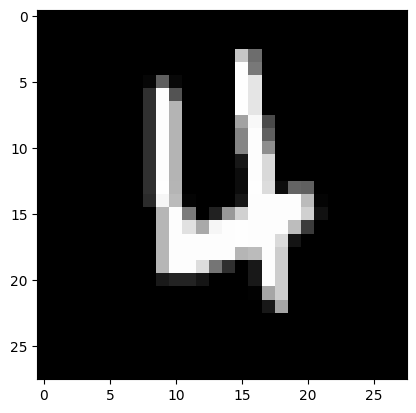

4    


In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.layer2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.layer4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.layer6 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.layer8 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer9 = nn.Flatten()
        self.drop1 = nn.Dropout(p=0.2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.drop3 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=10) 

    def forward(self, x):
        self.x1 = self.layer1(x)
        self.x2 = F.relu(self.layer2(self.x1))
        self.x3 = self.layer3(self.x2)
        self.x4 = F.relu(self.layer4(self.x3))
        self.x5 = self.layer5(self.x4)
        self.x6 = F.relu(self.layer6(self.x5))
        self.x7 = self.layer7(self.x6)
        self.x8 = F.relu(self.layer8(self.x7))
        self.x9 = self.layer9(self.x8)
        self.x10 = self.drop1(self.x9)
        
        self.x11 = F.relu(self.fc1(self.x10))
        self.x12 = self.drop2(self.x11)
        self.x13 = F.relu(self.fc2(self.x12))
        self.x14 = self.drop3(self.x13)
        self.x15 = F.softmax(self.fc3(self.x14), dim = 1)
            
        return self.x15

net = Net()

In [6]:
def hook(module, input, output):
    output_tensors.append(output)

net.fc2.register_forward_hook(hook)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [8]:
epochs = 4
patience = 5  # Define the number of epochs to tolerate before early stopping
best_loss = float('inf')
counter = 0

y = []
images = []

for epoch in range(epochs):
    output_tensors = []
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        if epoch == epochs-1:
            images.append(inputs)
            y.append(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:  # print every 1000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0
    
    # Calculate test loss
    test_loss = 0.0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    # Print test loss for the epoch
    print(f"Test Loss: {test_loss / len(testloader)}")
    
    # Check for early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
        # Save the best model
        torch.save(net.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            images.append(inputs)
            y.append(labels)
            print(f"Early stopping at epoch {epoch + 1}")
            break
    
print("Finished Training")

[1,  1000] loss: 1.145
[1,  2000] loss: 1.067
[1,  3000] loss: 0.976
[1,  4000] loss: 0.937
[1,  5000] loss: 0.899
[1,  6000] loss: 0.866
[1,  7000] loss: 0.840
[1,  8000] loss: 0.830
[1,  9000] loss: 0.812
[1, 10000] loss: 0.808
[1, 11000] loss: 0.795
[1, 12000] loss: 0.784
[1, 13000] loss: 0.794
[1, 14000] loss: 0.783
[1, 15000] loss: 0.782
[1, 16000] loss: 0.783
[1, 17000] loss: 0.773
[1, 18000] loss: 0.770
[1, 19000] loss: 0.773
[1, 20000] loss: 0.773
[1, 21000] loss: 0.762
[1, 22000] loss: 0.765
[1, 23000] loss: 0.774
[1, 24000] loss: 0.762
[1, 25000] loss: 0.772
[1, 26000] loss: 0.768
[1, 27000] loss: 0.762
[1, 28000] loss: 0.764
[1, 29000] loss: 0.764
[1, 30000] loss: 0.763
[1, 31000] loss: 0.754
[1, 32000] loss: 0.766
[1, 33000] loss: 0.765
[1, 34000] loss: 0.754
[1, 35000] loss: 0.760
[1, 36000] loss: 0.764
[1, 37000] loss: 0.752
[1, 38000] loss: 0.754
[1, 39000] loss: 0.752
[1, 40000] loss: 0.757
[1, 41000] loss: 0.752
[1, 42000] loss: 0.762
[1, 43000] loss: 0.750
[1, 44000] 

In [9]:
# Evaluating the trained model on test data
net.load_state_dict(torch.load('best_model.pth'))
net.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f} %')

Test Accuracy: 97.81 %


In [10]:
#torch.save(net.state_dict(), f"cnn_trained_{epochs}_epch.pth")
torch.save(images, "train_images_MNIST.pth")
torch.save(output_tensors, "train_tensors_MNIST.pth")
torch.save(y, "train_labels_MNIST.pth")

In [14]:
torch.save(net.state_dict(), 'model.pth')
net2 = torch.load('model.pth')

In [18]:
dict(net2).keys()

dict_keys(['layer1.weight', 'layer1.bias', 'layer3.weight', 'layer3.bias', 'layer5.weight', 'layer5.bias', 'layer7.weight', 'layer7.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])